# Stock Market Price Movement Prediction
## Part 3: Model Training & Evaluation

This notebook loads the `fully_processed_stock_data.csv` file created in the preprocessing step. It then trains and evaluates the three models proposed in the project pitch:
1.  **Logistic Regression** (Baseline)
2.  **Random Forest Classifier**
3.  **Support Vector Machine (SVM)**

Evaluation is performed using Accuracy, Precision, Recall, F1-Score, and Confusion Matrices.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    classification_report
)

plt.style.use('ggplot')
sns.set_palette('colorblind')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
try:
    df = pd.read_csv('fully_processed_stock_data.csv')
    df['Date'] = pd.to_datetime(df['Date'])
    print("Data loaded successfully.")
    print(f"Shape of data: {df.shape}")
except FileNotFoundError:
    print("Error: 'fully_processed_stock_data.csv' not found.")
    print("Please make sure the file is in the same directory as this notebook.")

if 'df' in locals():
    df.info()
    print(df.head())

Data loaded successfully.
Shape of data: (64232, 46)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64232 entries, 0 to 64231
Data columns (total 46 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Date                           64232 non-null  datetime64[ns]
 1   Close                          64232 non-null  float64       
 2   High                           64232 non-null  float64       
 3   Low                            64232 non-null  float64       
 4   Open                           64232 non-null  float64       
 5   Volume                         64232 non-null  int64         
 6   Ticker                         64232 non-null  object        
 7   Daily_Return                   64232 non-null  float64       
 8   Daily_Range                    64232 non-null  float64       
 9   Price_Change                   64232 non-null  float64       
 10  Day_of_Week                  

In [ ]:
if 'df' in locals():
    target_col = 'Target'
    cols_to_drop = [
        'Date', 'Ticker', 'Target', 
        'Close', 'High', 'Low', 'Open', 'Volume' 
    ]
    
    feature_columns = [col for col in df.columns if col not in cols_to_drop]
    
    print(f"Target column: {target_col}")
    print(f"Total features: {len(feature_columns)}")
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    initial_rows = len(df)
    df.dropna(subset=feature_columns + [target_col], inplace=True)
    final_rows = len(df)
    print(f"Dropped {initial_rows - final_rows} rows due to NaN values.")

    X = df[feature_columns]
    y = df[target_col].astype(int)
    
    print(f"Features (X) shape: {X.shape}")
    print(f"Target (y) shape: {y.shape}")

Target column: Target
Total features: 38
Dropped 0 rows due to NaN values.
Features (X) shape: (64232, 38)
Target (y) shape: (64232,)


## Time-Series Train-Test Split

**Crucial Step:** For financial time-series data, we **cannot** use a random split (`train_test_split`). This would cause data leakage, as we'd be training on future data to predict the past.

In [ ]:
if 'df' in locals():
    df_sorted = df.sort_values(by='Date')
    
    X = df_sorted[feature_columns]
    y = df_sorted[target_col].astype(int)
    
    test_size_pct = 0.20
    split_index = int(len(df_sorted) * (1 - test_size_pct))
    
    X_train = X.iloc[:split_index]
    X_test = X.iloc[split_index:]
    y_train = y.iloc[:split_index]
    y_test = y.iloc[split_index:]
    
    print(f"Total samples: {len(X)}")
    print(f"Training samples: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
    print(f"Test samples: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
    print("---")
    print(f"Training dates: {df_sorted.iloc[0]['Date'].date()} to {df_sorted.iloc[split_index-1]['Date'].date()}")
    print(f"Test dates:     {df_sorted.iloc[split_index]['Date'].date()} to {df_sorted.iloc[-1]['Date'].date()}")
    print("---")
    print(f"Training class balance (UP): {y_train.mean()*100:.2f}%")
    print(f"Test class balance (UP):     {y_test.mean()*100:.2f}%")

Total samples: 64232
Training samples: 51385 (80.0%)
Test samples: 12847 (20.0%)
---
Training dates: 2016-08-19 to 2023-12-05
Test dates:     2023-12-05 to 2025-10-03
---
Training class balance (UP): 53.36%
Test class balance (UP):     52.72%


## Feature Scaling

Models like Logistic Regression and SVM are sensitive to the scale of features. I will use `StandardScaler` to scale our data.

I will **fit** the scaler *only* on the `X_train` data and then use it to **transform** both `X_train` and `X_test`. This prevents any information from the test set from leaking into the training process.

In [ ]:
if 'X_train' in locals():
    scaler = StandardScaler()
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print("Feature scaling complete.")
    print(f"Original X_train mean (sample): {X_train.iloc[0].mean():.4f}")
    print(f"Scaled X_train mean (sample):   {X_train_scaled[0].mean():.4f}")

Feature scaling complete.
Original X_train mean (sample): 47502203.0183
Scaled X_train mean (sample):   -0.6095


## Model Training & Evaluation


In [ ]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000, solver='liblinear'),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100, n_jobs=-1),
    "Support Vector Machine (SVM)": SVC(random_state=42, kernel='rbf') # Using RBF kernel as a strong default
}

results = {}

def evaluate_model(name, y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    print(f"--- {name} --- ")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f} (for class 1 'UP')")
    print(f"Recall:    {recall:.4f} (for class 1 'UP')")
    print(f"F1-Score:  {f1:.4f} (for class 1 'UP')")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))
    
    cm = confusion_matrix(y_true, y_pred)
    return {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1-Score": f1, "CM": cm}


In [ ]:
if 'models' in locals():
    for name, model in models.items():
        print(f"Training {name}...")
        
        if name == "Random Forest":
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        else:
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
        
        print(f"Evaluating {name}...")
        results[name] = evaluate_model(name, y_test, y_pred)
        print("="*60 + "\n")
else:
    print("Models or data not defined. Please run previous cells.")

Training Logistic Regression...
Evaluating Logistic Regression...
--- Logistic Regression --- 
Accuracy:  0.5011
Precision: 0.5305 (for class 1 'UP')
Recall:    0.4667 (for class 1 'UP')
F1-Score:  0.4966 (for class 1 'UP')

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.54      0.51      6074
           1       0.53      0.47      0.50      6773

    accuracy                           0.50     12847
   macro avg       0.50      0.50      0.50     12847
weighted avg       0.50      0.50      0.50     12847


Training Random Forest...
Evaluating Random Forest...
--- Random Forest --- 
Accuracy:  0.4976
Precision: 0.5466 (for class 1 'UP')
Recall:    0.2764 (for class 1 'UP')
F1-Score:  0.3671 (for class 1 'UP')

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.74      0.58      6074
           1       0.55      0.28      0.37      6773

    accuracy                  

## Compare Results

Model Performance Comparison:
                              Accuracy Precision    Recall  F1-Score
Logistic Regression           0.501129  0.530547  0.466706  0.496583
Random Forest                 0.497626  0.546569  0.276392  0.367131
Support Vector Machine (SVM)  0.500272  0.568757  0.215562  0.312634


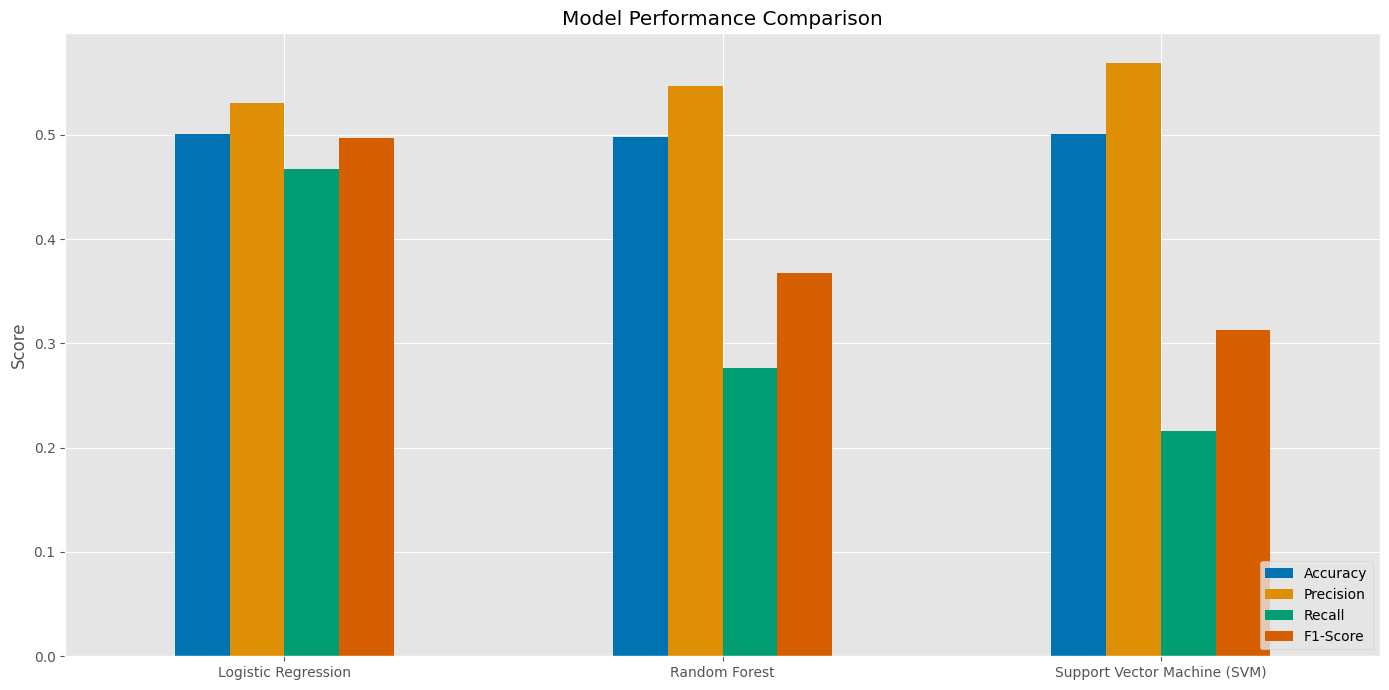

In [ ]:
if 'results' in locals() and results:
    results_df = pd.DataFrame(results).T.drop(columns='CM')
    
    print("Model Performance Comparison:")
    print(results_df.sort_values(by='F1-Score', ascending=False))
    
    results_df.astype(float).plot(kind='bar', figsize=(14, 7), title='Model Performance Comparison')
    plt.ylabel('Score')
    plt.xticks(rotation=0)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
else:
    print("No results to display. Please run the model training cell.")

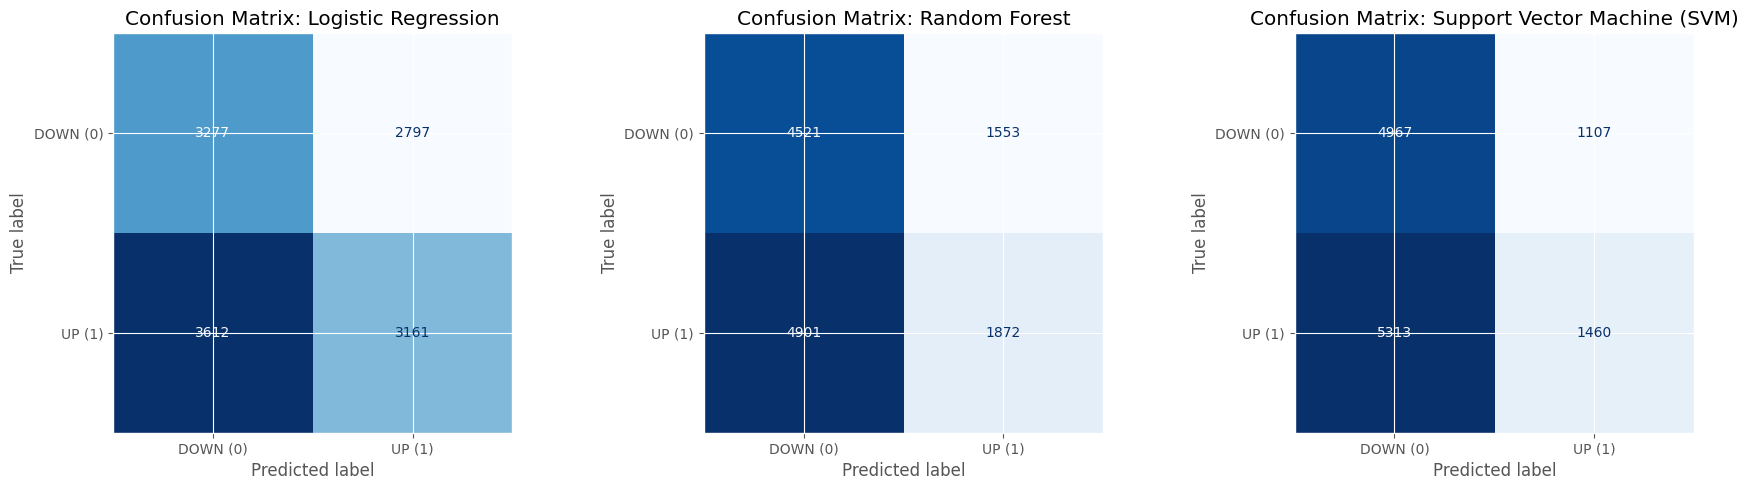

In [ ]:
if 'results' in locals() and results:
    num_models = len(models)
    fig, axes = plt.subplots(1, num_models, figsize=(6 * num_models, 5))
    
    if num_models == 1:
        axes = [axes]
        
    for ax, (name, res) in zip(axes, results.items()):
        disp = ConfusionMatrixDisplay(confusion_matrix=res['CM'], display_labels=['DOWN (0)', 'UP (1)'])
        disp.plot(ax=ax, cmap='Blues', colorbar=False)
        ax.set_title(f"Confusion Matrix: {name}")
        
    plt.tight_layout()
    plt.show()
else:
    print("No results to display. Please run the model training cell.")


--- Random Forest Feature Importance ---
Top 20 Most Important Features:
                          Feature  Importance
28                    Momentum_10    0.034268
0                    Daily_Return    0.034196
33           Cumulative_Return_10    0.033753
14                            RSI    0.033555
35                Volume_Ratio_20    0.033490
18                            OBV    0.033224
22                    Volume_Lag1    0.032787
2                    Price_Change    0.032622
30                 High_Low_Ratio    0.032062
1                     Daily_Range    0.031958
17                       BB_Width    0.031742
36       Price_Volume_Interaction    0.031547
29                    Momentum_20    0.031243
6                Daily_Volatility    0.031143
31               Close_Open_Ratio    0.030899
24               Close_Roll_Std_5    0.030897
32            Cumulative_Return_5    0.030897
27                     Momentum_5    0.030679
26              Close_Roll_Std_10    0.030419
37  Vo

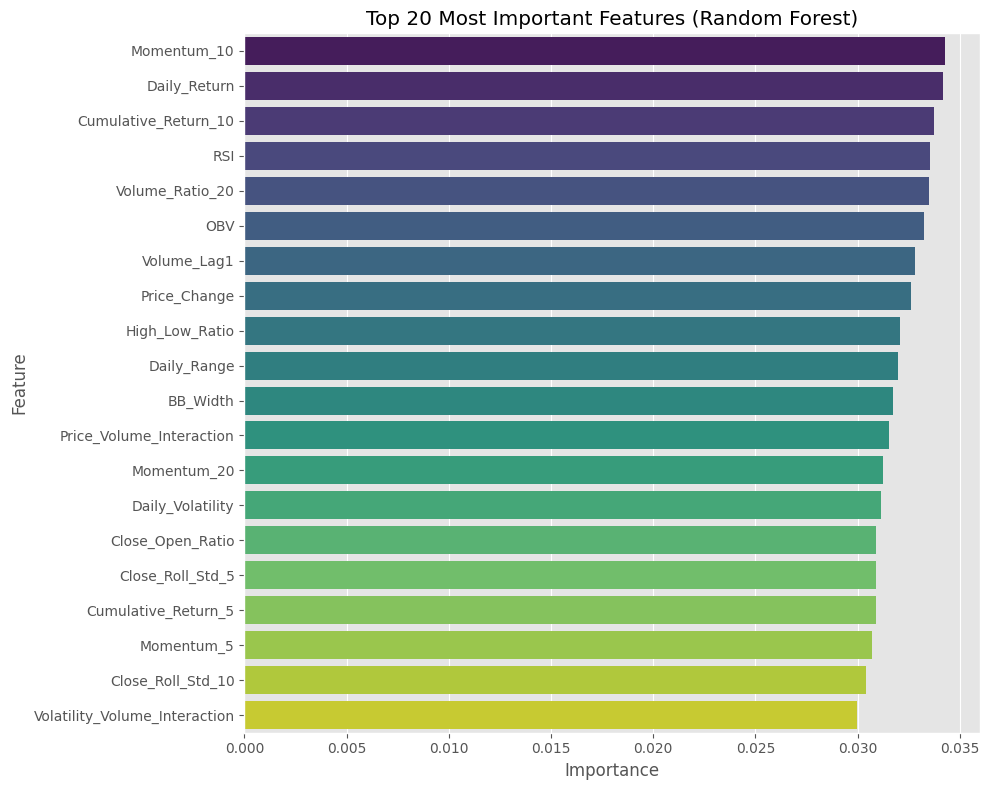

In [ ]:
if 'Random Forest' in models:
    print("\n--- Random Forest Feature Importance ---")
    rf_model = models["Random Forest"]
    
    importances = rf_model.feature_importances_
    feature_names = X_train.columns
    
    fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    fi_df = fi_df.sort_values(by='Importance', ascending=False)
    
    print("Top 20 Most Important Features:")
    print(fi_df.head(20))
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=fi_df.head(20), palette='viridis')
    plt.title('Top 20 Most Important Features (Random Forest)')
    plt.tight_layout()
    plt.show()
